In [1]:
import pickle
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from gala.coordinates import reflex_correct

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import gala.coordinates as gc

In [3]:
import numpy as np
import scipy.stats


def getDust(G, bp, rp, ebv, maxnit=10):
    """ Compute the Gaia extinctions assuming relations from Babusieux
    Arguments: G, bp, rp, E(B-V)
    maxnit -- number of iterations
    Returns extinction in G,bp, rp
    Author: Sergey Koposov skoposov@cmu.edu
    """
    c1, c2, c3, c4, c5, c6, c7 = [0.9761, -0.1704,
                                  0.0086, 0.0011, -0.0438, 0.0013, 0.0099]
    d1, d2, d3, d4, d5, d6, d7 = [
        1.1517, -0.0871, -0.0333, 0.0173, -0.0230, 0.0006, 0.0043]
    e1, e2, e3, e4, e5, e6, e7 = [
        0.6104, -0.0170, -0.0026, -0.0017, -0.0078, 0.00005, 0.0006]
    A0 = 3.1*ebv
    P1 = np.poly1d([c1, c2, c3, c4][::-1])

    def F1(bprp): return np.poly1d(
        [c1, c2, c3, c4][::-1])(bprp)+c5*A0+c6*A0**2+c7*bprp*A0

    def F2(bprp): return np.poly1d(
        [d1, d2, d3, d4][::-1])(bprp)+d5*A0+d6*A0**2+d7*bprp*A0

    def F3(bprp): return np.poly1d(
        [e1, e2, e3, e4][::-1])(bprp)+e5*A0+e6*A0**2+e7*bprp*A0
    xind = np.isfinite(bp+rp+G)
    curbp = bp-rp
    for i in range(maxnit):
        AG = F1(curbp)*A0
        Abp = F2(curbp)*A0
        Arp = F3(curbp)*A0
        curbp1 = bp-rp-Abp+Arp

        delta = np.abs(curbp1-curbp)[xind]
        #print(scipy.stats.scoreatpercentile(delta[np.isfinite(delta)], 99))
        curbp = curbp1
    AG = F1(curbp)*A0
    Abp = F2(curbp)*A0
    Arp = F3(curbp)*A0
    return AG, Abp, Arp


In [4]:
def calc_distance(g, Ag):
    #Ag = 2.5*ebv
    gmag = g-Ag
    dist = 10.*10.**(0.2*(gmag-0.5))*1e-3
    return dist

In [5]:
savedir = '/Users/landerson/Dropbox\ \(Simons\ Foundation\)/RRLyraeGaiaSprint/'

In [6]:
with open('gaiaRRlyrae.pkl', 'rb') as f:
    d = Table(pickle.load(f))


In [7]:
d.keys()

['ra',
 'dec',
 'pmra',
 'pmdec',
 'parallax',
 'parallax_error',
 'int_average_g',
 'int_average_g_error',
 'g_absorption',
 'g_absorption_error',
 'pmra_error',
 'pmdec_error',
 'pmra_pmdec_corr',
 'ebv',
 'peak_to_peak_g',
 'num_clean_epochs_g',
 'astrometric_excess_noise',
 'phot_bp_mean_mag',
 'phot_rp_mean_mag',
 'g_transit_time',
 'g_transit_flux',
 'pf',
 'best_classification',
 'source_id']

In [67]:
Ag, Abp, Arp = getDust(d['int_average_g'], d['phot_bp_mean_mag'], d['phot_rp_mean_mag'], d['ebv'])

/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in multiply
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:35: RuntimeWarning: overflow encountered in add
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


In [68]:
bprp = (d['phot_bp_mean_mag'] - Abp) - (d['phot_rp_mean_mag'] - Arp)
distances = calc_distance(d['int_average_g'], Ag)
c = coord.SkyCoord(ra=d['ra']*u.deg, 
                   dec=d['dec']*u.deg, 
                  distance=distances*u.kpc)

cGal = c.transform_to(coord.Galactocentric)

In [69]:
cSag = c.transform_to(gc.Sagittarius)

/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):


In [70]:
cGalactic = c.transform_to(coord.Galactic)

/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in greater
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):


In [71]:
import astropy

In [72]:
astropy.__version__

'3.0.2'

In [73]:
good = ~np.isnan(d['pmra']) & \
       ~np.isnan(d['pmdec']) & \
       (d['ebv'] < 5) & (bprp < 1) & (Ag < 5) & \
       (d['best_classification'] == 'RRab') & \
       (np.abs(cGal.z) > 1*u.kpc) & \
       (np.abs(cSag.Beta) > 10.*u.deg) & \
       (np.sqrt((cGalactic.l - 280.4652*u.deg)**2. + (cGalactic.b - -32.8884*u.deg)**2) > 15*u.deg) & \
       (np.sqrt((cGalactic.l - 302.8084*u.deg)**2  + (cGalactic.b - -44.3277*u.deg)**2) > 10*u.deg)


/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:639: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in less
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:646: RuntimeWarning: invalid value encountered in greater_equal
  if np.any(self_angle < wrap_angle_floor) or np.any(self_angle >= wrap_angle):
/anaconda3/lib/python3.6/site-packages/astropy/coordinates/angles.py:529: RuntimeWarning: invalid value encountered in less
  if np.any(angles.value < lower) or np.any(angles.value > upper):
/anaconda3/lib/python3.6/site-packages/a

In [74]:
data = d[good]

In [75]:
Ag, Abp, Arp = getDust(data['int_average_g'], data['phot_bp_mean_mag'], data['phot_rp_mean_mag'], data['ebv'])

In [76]:
bprp = (data['phot_bp_mean_mag'] - Abp) - (data['phot_rp_mean_mag'] - Arp)

In [77]:
distances = calc_distance(data['int_average_g'], Ag)
c = coord.SkyCoord(ra=data['ra']*u.deg, 
                   dec=data['dec']*u.deg, 
                   pm_ra_cosdec=data['pmra']*u.mas/u.yr,
                   pm_dec=data['pmdec']*u.mas/u.yr,
                   distance = distances*u.kpc, 
                   radial_velocity=0.*u.km/u.s)
cCorrect = reflex_correct(c)
cGal = cCorrect.transform_to(coord.Galactic)

In [78]:
cGalactic = cCorrect.transform_to(coord.Galactic)

In [79]:
cGalTable = Table()
cGalTable['l'] = cGalactic.l
cGalTable['b'] = cGalactic.b
cGalTable['pm_l_cosb'] = cGalactic.pm_l_cosb
cGalTable['pm_b'] = cGalactic.pm_b
cGalTable['distance'] = distances




In [80]:
cGalTable.write('rrlyraeDynamics.txt', format='ascii')

In [81]:
vl = (cGalactic.pm_l_cosb*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())
vb = (cGalactic.pm_b*cGalactic.distance).to(u.km/u.s, equivalencies=u.dimensionless_angles())


In [82]:
cGal.set_representation_cls('cartesian')

In [83]:
c.shape

(42483,)

Text(0.5,1,'distances')

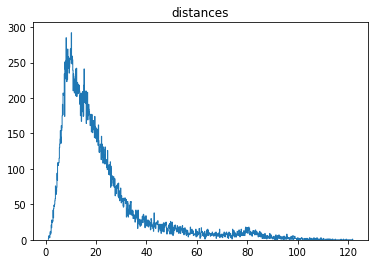

In [84]:
plt.hist(distances[~np.isnan(distances)], bins=1000, histtype='step')
plt.title('distances')

In [85]:
np.isnan(cGal.U).sum()
#for k in data.keys():
#    print(data[k][np.isnan(cGal.U)])
print(distances[np.isnan(cGal.U)], Ag[np.isnan(cGal.U)])

int_average_g
------------- ebv
---


In [86]:
locgalaxiesfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/NearbyGalaxies.dat'
locgaldata = Table.read(locgalaxiesfile, format='ascii')
gcfile = '/Users/landerson/Dropbox (Simons Foundation)/data/Misc/Harris-globclust.fits'
gcdata = Table.read(gcfile, format='fits')
locGalc = coord.SkyCoord(ra=locgaldata['RA'], dec=locgaldata['Dec'], unit=(u.hourangle, u.deg))
gcc     = coord.SkyCoord(ra=gcdata['ra'],     dec=gcdata['dec'], unit=(u.hourangle, u.deg))

locGalcGal = locGalc.transform_to(coord.Galactic)
gccGal = gcc.transform_to(coord.Galactic)

In [87]:
from sklearn.neighbors import KDTree as kdtree
import pandas as pd
import matplotlib as mpl

In [88]:
treedata = pd.DataFrame(data={'u':cGal.u/(1.*u.kpc), 
                              'v':cGal.v/(1.*u.kpc), 
                              'w':cGal.w/(1.*u.kpc),
                              'U':cGal.U/(10*u.km/u.s),
                              'V':cGal.V/(10*u.km/u.s), 
                              'W':cGal.W/(10*u.km/u.s)})

In [89]:
#treedataHigh = treedata.iloc[np.where(np.abs(cGalactic.b) >= 30.*u.deg)[0]]
#cGalacticHigh = cGalactic[np.abs(cGalactic.b) >= 30.*u.deg]

Text(0,0.5,'b')

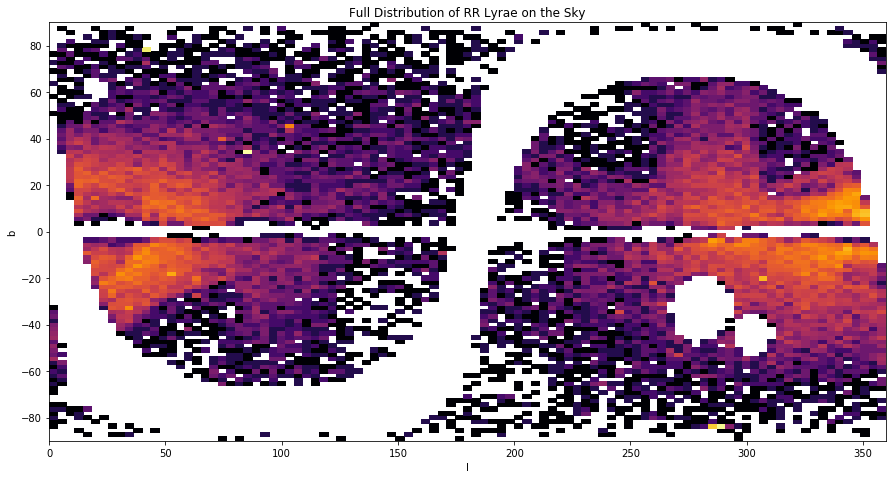

In [90]:
fig, ax = plt.subplots(figsize=(15, 10), subplot_kw={'aspect': 'equal'})
nbins = 100
xbins = np.linspace(0, 360, nbins)
ybins = np.linspace(-90, 90, nbins)

H, xe, ye = np.histogram2d(cGalactic.l, cGalactic.b, bins=(xbins, ybins))
im = ax.pcolormesh(xe, ye, H.T,
      cmap='inferno', norm=mpl.colors.LogNorm())#, vmax=20) #, vmin=-100, vmax=100)
ax.set_title('Full Distribution of RR Lyrae on the Sky')
ax.set_xlabel('l')
ax.set_ylabel('b')

In [91]:
tree = kdtree(treedata)

In [92]:
radius = 3.0


In [93]:
(ind, dist) = tree.query_radius(treedata, radius, count_only = False, return_distance = True)

In [94]:
maxMembers= 2
minMembers = 2
clumps = []
for i in ind:
    if (len(i)>=minMembers) & (len(i)<=maxMembers): 
        clumps.append(i)
print(len(clumps))

7913


In [67]:
for c in clumps:
    if len(c) > 2: print(len(c))

3
3
3
3
3
3
4
4
4
4
5
4
3
4
3
3
3
3
3
3
3
4
7
3
3
3
3
5
3
3
4
3
4
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
3
3
3
3
4
3
3
3
4
4
6
5
3
3
3
3
3
4
3
3
3
3
3
3
3
3
5
4
4
3
3
3
3
4
3
3
4
3
3
4
3
3
3
3
3
4
4
4
4
3
3
3
3
3
3
3
3
3
3
4
3
3
5
4
4
3
3
4
3
4
3
5
3
3
3
3
3
3
4
3
3
3
4
3
4
3
3
3
3
3
3
3
3
3
3
3
4
3
3
4
4
4
3
3
4
3
3
4
4
3
3
3
3
3
3
3
6
3
3
3
6
3
4
3
3
3
5
5
3
3
3
3
3
3
4
3
3
4
3
3
3
3
3
4
3
3
4
3
10
3
4
4
3
3
3
5
3
3
3
3
6
3
4
5
4
3
4
4
4
3
4
3
3
3
4
3
3
3
3
3
4
3
4
3
4
3
3
5
3
3
3
3
3
4
3
4
3
3
3
4
3
3
3
4
3
3
4
3
4
3
3
4
3
3
3
7
3
3
3
3
5
3
3
4
4
3
3
4
3
3
3
5
3
3
3
5
4
5
3
3
3
3
3
3
3
4
8
9
9
8
3
7
8
8
3
3
4
4
3
3
3
3
4
3
3
3
7
5
4
4
3
3
6
3
3
3
3
3
3
4
3
3
3
7
3
4
5
3
5
3
3
3
4
3
3
3
3
3
3
3
3
3
3
4
3
3
4
5
3
3
3
3
4
4
6
3
4
8
6
4
6
3
3
3
4
3
3
4
4
3
7
3
3
4
4
3
3
8
9
12
10
12
4
12
11
13
10
13
12
11
3
95
106
107
109
108
107
108
106
107
106
111
100
104
109
105
105
105
101
106
105
106
105
106
6
106
110
76
109
106
107
110
102
11
109
106
103
98
24
101
96
61
10
25
3
3
66
108
100
10
45
109
8
2

KeyboardInterrupt: 

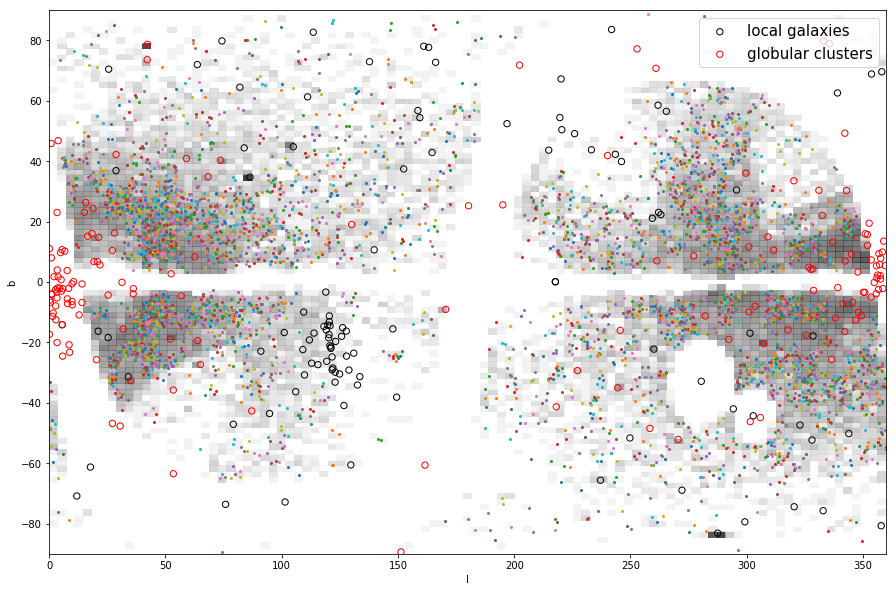

In [95]:
#clumpTable = Table()
clumpTable = pd.DataFrame(columns = ('indices', 'ra', 'dec', 'pmra', 'pmdec', 'distance', 'width', 'angularSizeR', 'l', 'b'))
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
axSky.pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
ti = 0
distToKnown = 5.0 #deg
widthOfClump = 1 # kpc
maxSameAsBefore = 1
for j in range(len(clumps)):
    #check that it's small in physical space
    small = treedata.iloc[clumps[j]]
    width = np.max((small.u - np.mean(small.u))**2 + (small.v - np.mean(small.v))**2 + (small.w - np.mean(small.w))**2) #kpc
    if width < widthOfClump :
        #check that it isn't something already known 
        co = cGalactic[clumps[j]]
        dist_known = np.zeros(len(co) + len(co))
        for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
            dist_known[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
            dist_known[ii + len(co)] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
        #print(np.min(dist_known))
        lmcdist = np.sqrt((ll.value - 280.4652)**2. + (bb.value - -32.8884)**2)
        smcdist = np.sqrt((ll.value - 302.8084)**2  + (bb.value - -44.3277)**2)
        if (np.min(dist_known) > distToKnown) & (lmcdist > 10) & (smcdist > 10): 
            #check that you haven't already plotted it 
            samesies = 0
            for k in range(j):
                same = np.in1d(clumps[j], clumps[k])
                #print(same, np.sum(same), j, k)
                samesies += np.sum(same)
            if (samesies < maxSameAsBefore+1):
                #color = next(colors)
                dnow= data[clumps[j]]
                clumpTable.loc[ti] = [clumps[j], dnow['ra'], dnow['dec'], dnow['pmra'], dnow['pmdec'], 
                                      distances[clumps[j]], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi), 
                                     np.median(cGalactic.l[clumps[j]]), np.median(cGalactic.b[clumps[j]])]
                ti += 1
                #print(samesies, clumps[j], dnow['ra'][0], dnow['dec'][0], width, np.max(width*u.kpc/cGalactic[clumps[j]].distance*180./np.pi))
                axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*2)#, c=color)
axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
axSky.legend(fontsize=15)
figSky.savefig('allsky_pairs.png')
#plt.close(fig)

In [96]:
len(clumpTable)

2268

In [97]:
clumpTable.to_pickle('clumpTablePairs')

In [80]:
print(np.sqrt(np.var(clumpTable.iloc[0]['pmra']))*4, np.sqrt(np.var(clumpTable.iloc[0]['pmdec']))*4)

0.06485332272596 0.30984539240430387


In [114]:
from os import path
import sqlutilpy as sqlutil
def queryDatabase(query, columns, post_query, cache_file='db.pickle', queryPro=None):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        if queryPro is not None:
            res = sqlutil.get(queryPro,
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)
        else:
            res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

/anaconda3/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [103]:
from scipy.interpolate import interp1d
dataCMD_15 = Table.read('MIST_iso_5b18346c0ece6.iso.cmd', format='ascii.commented_header', header_start=12)
dataCMD_10 = Table.read('MIST_iso_5b19718e29c20.iso.cmd', format='ascii.commented_header', header_start=12)
dataCMD_05 = Table.read('MIST_iso_5b19717ee7821.iso.cmd', format='ascii.commented_header', header_start=12)
dataCMD_20 = Table.read('MIST_iso_5b1aa1d56d073.iso.cmd', format='ascii.commented_header', header_start=12)

-1.9285079449866906
-2.498738805154451
-2.864049043887721


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


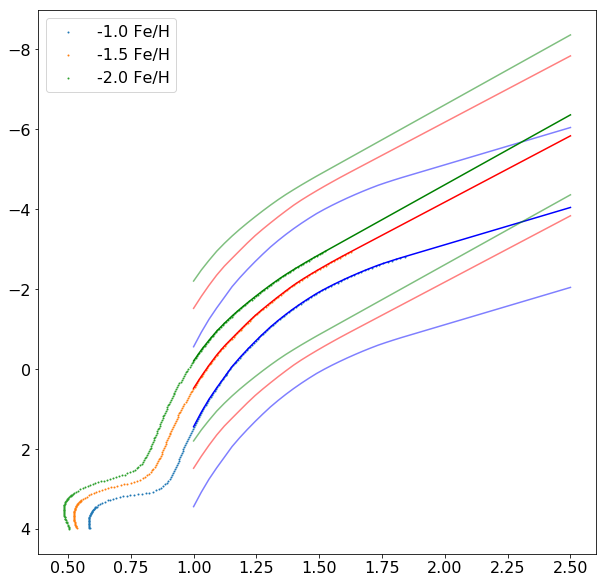

In [104]:
plt.figure(figsize=(10,10))
colors = ['blue', 'red', 'green', 'black']
for dataCMD, l, c in zip([dataCMD_10, dataCMD_15, dataCMD_20], ['-1.0', '-1.5', '-2.0'], colors):
    good = (dataCMD['phase'] < 3) & (dataCMD['phase'] > -1) & (dataCMD['Gaia_G_DR2Rev'] < 4)
    plt.scatter(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good], s=1, label='{0} Fe/H'.format(l))

    f = interp1d(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good], fill_value='extrapolate')
    xx = np.linspace(1, 2.5)
    plt.plot(xx, f(xx), color=c)
    plt.plot(xx, f(xx)+2, alpha=0.5, color=c)
    plt.plot(xx, f(xx)-2, alpha=0.5, color=c)
    print(f(1.5))
plt.legend()
plt.gca().invert_yaxis()

In [105]:
clumpSky = coord.SkyCoord(ra=clumpTable['ra']*u.deg, dec=clumpTable['dec']*u.deg, distance=clumpTable['distance']*u.kpc)

In [106]:
clumpGal= clumpSky.transform_to(coord.Galactocentric)

In [107]:
r = np.sqrt(clumpGal.x.value**2 + clumpGal.y.value**2 + clumpGal.z.value**2)

(1, 377.45674414073244)

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


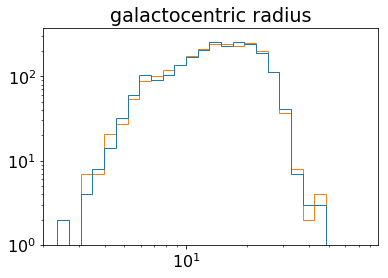

In [108]:
plt.hist(r, bins=np.logspace(-1, 1.8, 50), histtype='step', log=True)
plt.title('galactocentric radius')
plt.xscale('log')
plt.xlim(2, )
plt.ylim(1,)

In [109]:
len(clumpTable)

2268

In [ ]:
mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
             'sans-serif':['Helvetica'], 'size':16, 
             'weight':500, 'variant':'normal'}) 
dataCMD = dataCMD_15
good = (dataCMD['phase'] <3) & (dataCMD['phase'] > -1) & (dataCMD['Gaia_G_DR2Rev'] < 4)
f = interp1d(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], dataCMD['Gaia_G_DR2Rev'][good], fill_value='extrapolate')
xx = np.linspace(1, 2.5)

minStarsRGB = 3
maxMagDiff = 2
minRedColor = 1.25
minAngularDistance = 1.0 #deg
minSigPM = 0.5 #mas/yr
index_order = np.argsort(clumpTable['angularSizeR'].values)
#print(index_order[1])
minr = np.min(clumpTable['angularSizeR'])
print('distance, pmra, pmdec, pmraWidth, pmdecWidth, ra, dec, angular distance')
for ii, i in enumerate(range(len(index_order))):
    i = index_order[i]
    nstars = len(clumpTable.loc[i]['ra'])
    ra = clumpTable.loc[i]['ra'][0]
    dec = clumpTable.loc[i]['dec'][0]
    pmra = clumpTable.loc[i]['pmra'][0]
    pmdec = clumpTable.loc[i]['pmdec'][0]
    angular_distance = np.max((clumpTable.loc[i]['angularSizeR'], minAngularDistance))
    distance = clumpTable.loc[i]['distance'][0]
    #print(ra, dec, pmra, pmdec, angular_distance, distance)

    medra = np.median(clumpTable.loc[i]['ra'])
    meddec = np.median(clumpTable.loc[i]['dec'])
    pm2Max = pmra**2 + pmdec**2
    pmramed = np.median(clumpTable.loc[i]['pmra'])
    pmdecmed = np.median(clumpTable.loc[i]['pmdec'])
    pmrasig = np.max((np.sqrt(np.var(clumpTable.iloc[i]['pmra']))*4, minSigPM))
    pmdecsig = np.max((np.sqrt(np.var(clumpTable.iloc[i]['pmdec']))*4, minSigPM))
    maxParallax = 10./distance
    print(distance, pmramed, pmdecmed, pmrasig, pmdecsig, angular_distance)

    
    queryPro = """WITH x AS (SELECT  * FROM gaia_dr2.gaia_source AS gs WHERE q3c_radial_query(gs.ra, gs.dec, {0}, {1}, {2}))
    SELECT x.ra, x.dec, x.pmra, x.pmdec, phot_g_mean_mag, ebv, phot_bp_mean_mag, phot_rp_mean_mag
        FROM x
            WHERE parallax < {3} AND abs(pmra - {4:0.6f}) < {5:0.6f} AND abs(pmdec - {6:0.6f}) < {7:0.6f};""".format(medra, meddec, 
                                                                                                                         angular_distance, 
                                                                                                                         maxParallax, 
                                                                                                                         pmramed, pmrasig,
                                                                                                                         pmdecmed, pmdecsig)
    

    #columns = ['parallax', 'int_average_g', 'ebv', 'phot_bp_mean_mag', 'phot_rp_mean_mag']
    #query = """select {0} from gaia_dr2.gaia_source as gs, gaia_DR2.vari_rrlyrae as rr {1}"""
    #cuts = "WHERE ".format(ra, dec, angular_distance)
    query = ""
    columns = ""
    cuts = ""
    res = queryDatabase(query, columns, cuts, cache_file='rrlyrae_pairs_{0}.pkl'.format(ii), queryPro=queryPro)


    dnow = Table(res)
    Ag, Abp, Arp = getDust(dnow['phot_g_mean_mag'], dnow['phot_bp_mean_mag'], dnow['phot_rp_mean_mag'], dnow['ebv'])
    bprp = (dnow['phot_bp_mean_mag'] - Abp) - (dnow['phot_rp_mean_mag'] - Arp)
    MG = dnow['phot_g_mean_mag'] - Ag - 5.*np.log10(distance*1e3/10)
    
    red = bprp > minRedColor
    notTurnOff =  MG < 4.*bprp + 12
    
    if np.logical_or((np.sum((MG[red & notTurnOff] - f(bprp[red & notTurnOff])) <= maxMagDiff) > minStarsRGB), len(dnow) < 100) :

        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        if len(dnow) > 4000:
            HH, xx, yy = np.histogram2d(dnow['ra'], dnow['dec'], bins=100)
            im = ax[0].pcolormesh(xx, yy, HH.T,
              cmap='inferno', norm=mpl.colors.LogNorm())
        else:
            if len(dnow) < 100:
                size = 20
            else:
                size = 3
            ax[0].scatter(dnow['ra'], dnow['dec'], s=10, label=('{0:0.4f},{1:0.4f}'.format(medra, meddec)))
        ax[0].legend()
        ax[0].set_xlabel('ra')
        ax[0].set_ylabel('dec')

        if len(dnow) > 10000:
            xbins = np.linspace(0, 2.5, 50)
            ybins = np.linspace(10, 20, 200)
            HH, xx, yy = np.histogram2d(bprp, dnow['phot_g_mean_mag'] - Ag, bins=(xbins, ybins))
            im = ax[1].pcolormesh(xx, yy, HH.T,
              cmap='inferno', norm=mpl.colors.LogNorm())
            ax[1].invert_yaxis()
            ax[1].set_ylim(20, 10)
        else:
            if len(dnow) < 100:
                size = 20
            else:
                size = 3
            ax[1].scatter(bprp, dnow['phot_g_mean_mag'] - Ag, s=size)
            ax[1].set_xlim(0, 2.5)
            ax[1].set_ylim(20, 10)
        for dataCMD, l, c in zip([dataCMD_10, dataCMD_15, dataCMD_20], ['-1.0', '-1.5', '-2.0'], colors):
            good = (dataCMD['phase'] < 4) & (dataCMD['phase'] > -1)
            ax[1].scatter(dataCMD['Gaia_BP_DR2Rev'][good] - dataCMD['Gaia_RP_DR2Rev'][good], 
                          dataCMD['Gaia_G_DR2Rev'][good] + 5.*np.log10(distance*1e3/10), s=1, alpha=0.5, label='{0} Fe/H'.format(l), c='black')

        #ax[1].scatter(cmd_bprp, cmd_MG + 5.*np.log10(distance*1e3/10), s=3, alpha=0.1)
        ax[0].set_title('{0:0.2f} kpc'.format(distance))
        ax[1].set_xlabel('bp - rp')
        ax[1].set_ylabel('G')
        ax[1].set_title('{0} RRlyrae'.format(nstars))

        ax[2].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
        ax[2].scatter(clumpTable.loc[i]['l'], clumpTable.loc[i]['b'], s=100)
        ax[2].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies', alpha=0.5, zorder=np.inf)
        ax[2].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters', alpha=0.5, zorder=np.inf)
        ax[2].set_xlabel('l')
        ax[2].set_ylabel('b')
        ax[2].set_xlim(0, 360)
        ax[2].set_ylim(-90, 90)
        vtannow = np.sqrt(pmra**2 + pmdec**2)*4.*distance
        ax[2].set_title('{0:0.2f} km/s'.format(vtannow))
        plt.tight_layout()
        fig.savefig('cmd_rrlyrae_pairs_{0:02d}.png'.format(ii))
        plt.close(fig)

        #plt.gca().invert_yaxis()

distance, pmra, pmdec, pmraWidth, pmdecWidth, ra, dec, angular distance
18.359550961886892 -1.83448822731399 -2.17864666454796 0.5 0.5 1.0


/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in greater
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/astropy/table/column.py:965: RuntimeWarning: invalid value encountered in less
  return getattr(self.data, op)(other)
/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


6.381265436968355 -8.4684200000491 -17.9637261605969 0.5 0.5 1.0
20.389670801244414 0.0520764000865538 -2.83439378656611 0.5 0.5 1.0
6.503434405078669 -6.5454607541427 -11.2321260249682 0.5 0.5 1.0
43.82129397984194 2.3375223223736548 -0.330515339444237 0.5 0.5 1.0
11.901970041399691 -5.494593000223925 -2.556306945694055 0.6637936277505005 0.6064963705637796 1.0


/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:991: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


20.162268999897055 0.0908997222503452 -1.293438210489105 0.5 0.5 1.0
4.668510329411469 -2.41591460250388 -7.77197584140493 1.8724814417783602 0.5 1.0
15.6328084470087 -1.0290010401980065 -2.9911943582511302 0.585301888222814 0.5 1.0
24.165542201666522 -1.7384433649396298 -1.88605533055784 0.5 0.5 1.0
4.129245268810586 -8.165997895935716 -4.192085275649405 0.5 3.9452498976736203 1.0
24.632867483410774 -0.63332577921072 -0.5766614352387149 0.5 0.5 1.0
16.172478798778045 0.7498413016426465 -0.030231094402608797 0.6414621381727139 0.5 1.0
16.923612988671444 0.429839049876431 -2.61878797534505 0.5328819444019921 0.5 1.0
8.728005355254213 -5.560164761585336 -7.552120717864245 0.7991279183266595 0.8198190193463795 1.0
9.061684492178664 2.5645534742884752 -3.98416571020892 0.5 0.6683035124363998 1.0
17.323483160211026 0.4461185853080155 -4.114901704460015 0.5 0.5 1.0
23.963782242815157 0.044738907891269206 -2.22020640188487 0.5 0.5 1.0
14.855719265593041 1.0607562295241955 -1.3193742378945998 

/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: overflow encountered in multiply
  y = y * x + p[i]
/anaconda3/lib/python3.6/site-packages/numpy/lib/polynomial.py:680: RuntimeWarning: invalid value encountered in multiply
  y = y * x + p[i]


13.670145437679096 -2.35367554657278 -1.06625420342925 0.5109326079163203 0.5 1.0
31.709575385053125 -0.5040642531745705 -0.40200600276166354 0.5 0.5 1.0
27.50398809995582 0.6037529397605435 1.0599462641808919 0.5 0.5 1.0
22.247332628987355 -0.48377333662259503 -0.817067561013837 0.5 0.5 1.0
20.161125784453848 -1.607768577590305 -1.469399060215635 0.5 0.5 1.0
24.494006532508052 -0.6132324383811716 -1.111882832141605 0.5 0.5 1.0
22.974173940741917 -0.5068875943879245 -0.9007993587025165 0.5 0.5 1.0
29.98723103607817 -0.0584084292029656 -2.151763970318705 0.5 0.5 1.0
15.639296695701997 -1.085194592962222 -1.6233400235737752 0.7795247190899122 0.5 1.0
8.062825094261559 5.18320836776921 1.8188836876685501 0.83748217291404 1.1352896245467599 1.0
6.909201104779481 -13.29422786740785 -6.329729595801085 0.8538286430918021 0.5 1.0
22.995396366994093 -1.609402193989475 -1.6755958448737949 0.5 0.5 1.0
20.76485035005539 -1.79189456043636 -1.70548593019417 0.5 0.5 1.0
26.150577423307418 -0.90172259

/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


[7402 7360 7414 7062 7351 7586 7434 7405 7662 7561]
[9593 9745 9850 9060 9563 9541 9538 9560 9069 9544]
[9971 9848 9825 9759 9223 9961 9297 9912 9216 9250]
[22758 22885 22880 22245 22319 22519 22902 22327 22335 22842]
[54988 57700 53728 55066 57893 57696 57881 57689 55108 57658]
[55875 56120 56212 56254 55675 55851 56136 56112 56144 56192]


(-90, 90)

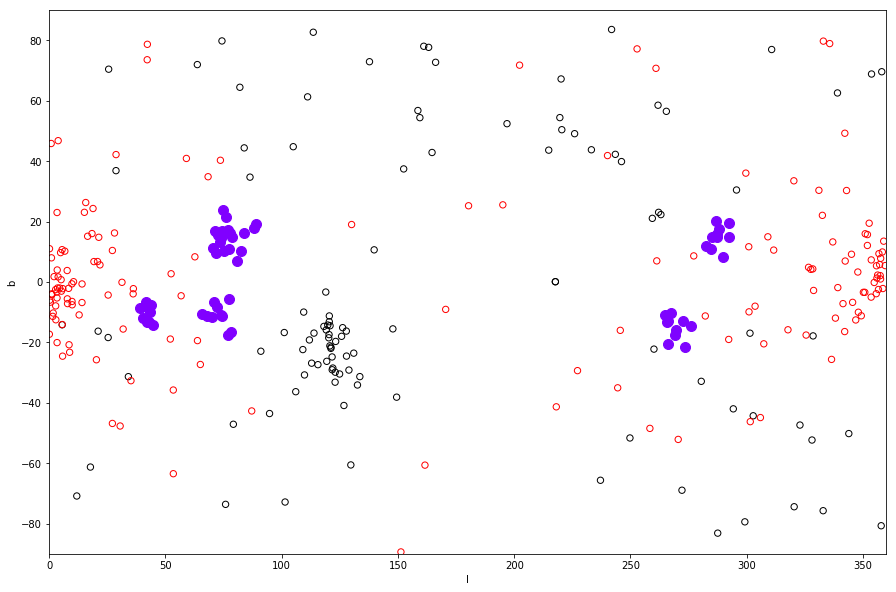

In [33]:
#figAll, axAll = plt.subplots()
figSky, axSky = plt.subplots(figsize=(15, 10))
colors=iter(plt.cm.rainbow(np.linspace(0,1,len(clumps))))
mpl.rc('font',**{'family':'sans-serif', 'serif':['Computer Modern Serif'], 
             'sans-serif':['Helvetica'], 'size':16, 
             'weight':500, 'variant':'normal'}) 
for j, ci in enumerate(clumps):
    samesies = 0
    for k in range(j):
        same = np.in1d(clumps[j], clumps[k])
        samesies += np.sum(same)
    #if clumps[j] != clumps[j-1]
    if samesies < 1:
        small = treedata.iloc[clumps[j]]
        co = cGalactic[clumps[j]]
        vll = vl[clumps[j]]
        vbb = vb[clumps[j]]
        dist_known_gal = np.zeros(len(co))
        dist_known_gcc = np.zeros(len(co))
        for ii, (ll, bb) in enumerate(zip(co.l, co.b)):
            dist_known_gal[ii] = np.min(np.sqrt((ll - locGalcGal.l)**2 + (bb - locGalcGal.b)**2).value)
            dist_known_gcc[ii] = np.min(np.sqrt((ll - gccGal.l)**2 + (bb - gccGal.b)**2).value)
        dist_known = np.concatenate((dist_known_gal, dist_known_gcc))
        if np.min(dist_known) < 5: 
            continue
        fig, ax = plt.subplots(ncols=4, figsize=(20, 5))
        xx = [co.l, co.b, co.l]
        yy = [co.b, co.distance, co.distance]
        vxx = [vll, vbb, vll]
        vyy = [vbb, np.zeros(len(vbb)), np.zeros(len(vll))]
        #xx = [small.u, small.v, small.w]
        #yy = [small.v, small.w, small.u]
        #vxx = [small.U, small.V, small.W]
        #vyy = [small.V, small.W, small.U]
        lxx = ['l', 'b', 'l']
        lyy = ['b', 'd', 'd']
        color = next(colors)
        for i, (x, y, vx, vy, lx, ly) in enumerate(zip(xx, yy, vxx, vyy, lxx, lyy)):
            ax[i].quiver(x, y, vx, vy, color=color)
            ax[i].set_xlabel(lx)
            ax[i].set_ylabel(ly)
            #axAll.quiver(x, y, vx, vy)
        ax[3].pcolormesh(xe, ye, H.T, cmap='Greys', norm=mpl.colors.LogNorm(), alpha=0.75)
        ax[3].scatter(co.l, co.b, s=40, c=color)
        ax[3].scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black', label='local galaxies')
        ax[3].scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red', label='globular clusters')
        ax[3].set_xlabel('l')
        ax[3].set_ylabel('b')
        ax[3].set_xlim(0, 360)
        ax[3].set_ylim(-90, 90)
        #ax[3].legend(fontsize=15)
        plt.tight_layout()
        fig.savefig('rrLyrae_kdtree_{0:03d}.png'.format(j))
        plt.close(fig)
        axSky.scatter(cGalactic.l[clumps[j]], cGalactic.b[clumps[j]], s=len(clumps[j])*10, c=color)
        print(clumps[j])
axSky.scatter(locGalcGal.l, locGalcGal.b, s=40, facecolor='none', edgecolor='black')
axSky.scatter(gccGal.l, gccGal.b, s=40, facecolor='none', edgecolor='red')
axSky.set_xlabel('l')
axSky.set_ylabel('b')
axSky.set_xlim(0, 360)
axSky.set_ylim(-90, 90)
#plt.close(fig)